This Notebook demonstrates the two interfaces of the `zappend` tool, namely the CLI and API.

## Prepare test data

In [1]:
import os
import os.path
import shutil
import xarray as xr
import numpy as np
import pyproj

First let's define a utility to remove non-empty directories:

In [2]:
def rmdir(path: str):
    if os.path.exists(path):
        shutil.rmtree(path)

In [3]:
def make_slice_dataset(img_size: tuple[int, int] = (720, 360),
                       doy: int = 0) -> xr.Dataset:
    """Prepare a time slice dataset."""
    
    w, h = img_size
    
    dx = dy = 360.0 / w
    x_data = np.linspace(-180+dx/2, 180-dx/2, w, dtype="float64")
    y_data = np.linspace(-90+dy/2, 90-dy/2, h, dtype="float64")
    x = xr.DataArray(x_data, dims="x")
    y = xr.DataArray(y_data, dims="y")

    dtime = np.timedelta64(24, 'h')
    time_data = np.arange(
        np.datetime64('2023-01-01') + (doy + 0.5) * dtime,
        np.datetime64('2023-01-01') + (doy + 1.5) * dtime,
        dtime,
        dtype='datetime64'
    )
    time = xr.DataArray(time_data, dims="time")
    
    crs = xr.DataArray(np.array(0), 
                       attrs=pyproj.CRS("EPSG:4326").to_cf())
    
    chl_data = np.full((1, h, w), doy / 100., dtype="float64")
    chl = xr.DataArray(chl_data,
                       dims=("time", "y", "x"),
                       attrs={"long_name": "Chlorophyll Concentration", 
                              "units": "mg/m^3"})
                       
    tsm_data = np.full((1, h, w), doy / 250., dtype="float64")                           
    tsm = xr.DataArray(tsm_data, 
                       dims=("time", "y", "x"),
                       attrs={"long_name": "Total Suspended Matter", 
                              "units": "mg/m^3"})                     
    
    return xr.Dataset(
        data_vars={"chl": chl, "tsm": tsm, "crs": crs},
        coords={"time": time, "y": y, "x": x}
    )

In [4]:
# Check slice
make_slice_dataset(doy=140)

<xarray.Dataset>
Dimensions:  (time: 1, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-21T12:00:00
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
Data variables:
    chl      (time, y, x) float64 1.4 1.4 1.4 1.4 1.4 ... 1.4 1.4 1.4 1.4 1.4
    tsm      (time, y, x) float64 0.56 0.56 0.56 0.56 ... 0.56 0.56 0.56 0.56
    crs      int32 0

Let's create `N` "slice" datasets as input.

In [5]:
N = 10

In [6]:
test_data_dir = "testdata"

rmdir(test_data_dir)
os.mkdir(test_data_dir)

slice_paths = []
for doy in range(N):
    slice_path = f"{test_data_dir}/slice-{doy:04d}.zarr"
    slice_paths.append(slice_path)
    slice_ds = make_slice_dataset(doy=doy)
    slice_ds.to_zarr(slice_path)

Path to the target dataset to be created:

In [7]:
target_path = f"{test_data_dir}/target.zarr"

## zappend CLI

In [8]:
!zappend --help

Usage: zappend [OPTIONS] [SLICES]...

  Create or update a Zarr dataset TARGET from slice datasets SLICES.

Options:
  -c, --config CONFIG    Configuration JSON or YAML file. If multiple are
                         passed, subsequent configurations are incremental to
                         the previous ones.
  -t, --target TARGET    Target Zarr dataset path or URI. Overrides the
                         'target_dir' configuration field.
  --dry-run              Run the tool without creating, changing, or deleting
                         any files.
  --help-config json|md  Show configuration help and exit.
  --help                 Show this message and exit.


Run the tool without any configuration:

In [9]:
!zappend -t {target_path} {" ".join(slice_paths)}

Check the result:

In [10]:
target_ds = xr.open_zarr(target_path)
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

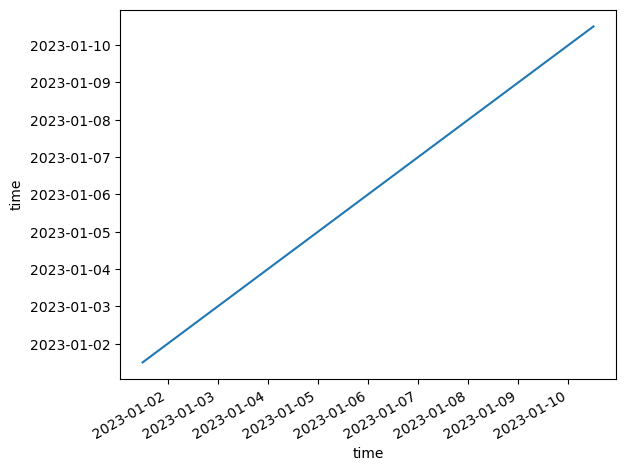

In [11]:
target_ds.time.plot()

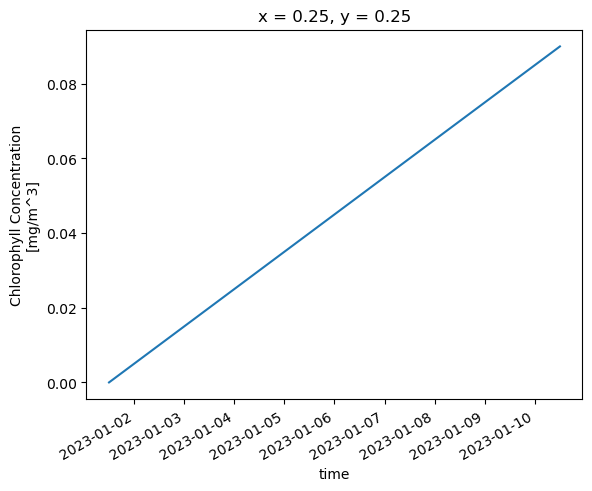

In [12]:
target_ds.chl.sel(x=0, y=0, method="nearest").plot()

Now we'll add some configuration. 
You can run `zappend --help-config md` to get configuration help, or do that programmatically:

In [13]:
from IPython.display import Markdown
from zappend.config import schema_to_md

In [14]:
Markdown(schema_to_md())

## Configuration for the `zappend` tool


### `version`

Configuration schema version. Allows the schema to evolve while still preserving backwards compatibility.
It's value is `1`.

### `target_dir`

Type _string_.
The URI or local path of the target Zarr dataset. Must be a directory.

### `target_storage_options`

Type _object_.
Options for the filesystem given by the URI of `target_dir`.

### `slice_engine`

Type _string_.
The name of the engine to be used for opening contributing datasets. Refer to the `engine` argument of the function `xarray.open_dataset()`.

### `slice_storage_options`

Type _object_.
Options for the filesystem given by the protocol of the URIs of contributing datasets.

### `slice_polling`

Defines how to poll for contributing datasets.
Must be one of the following:
* No polling, fail immediately if dataset is not available.
  It's value is `false`.
* Poll using default values.
  It's value is `true`.
* Type _object_.
  Polling parameters.
  The keys `interval`, `timeout` are required.
  
  * `interval`:
    Type _number_.
    Polling interval in seconds.
    Defaults to `2`.
  * `timeout`:
    Type _number_.
    Polling timeout in seconds.
    Defaults to `60`.
  

### `temp_dir`

Type _string_.
The URI or local path of the directory that will be used to temporarily store rollback information.

### `temp_storage_options`

Type _object_.
Options for the filesystem given by the protocol of `temp_dir`.

### `zarr_version`

The Zarr version to be used.
It's value is `2`.

### `fixed_dims`

Type _object_.
Specifies the fixed dimensions of the target dataset. Keys are dimension names, values are dimension sizes.
Object values are:
Type _integer_.

### `append_dim`

Type _string_.
The name of the variadic append dimension.
Defaults to `"time"`.

### `variables`

Type _object_.
Defines dimensions, encoding, and attributes for variables in the target dataset. Object property names refer to variable names. The special name `*` refers to all variables, which is useful for defining common values.
Object values are:
Type _object_.
Variable metadata.

* `dims`:
  Type _array_.
  The names of the variable's dimensions in the given order. Each dimension must exist in contributing datasets.
* `encoding`:
  Type _object_.
  Variable storage encoding. Settings given here overwrite the encoding settings of the first contributing dataset.
  
  * `dtype`:
    Storage data type
    Must be one of `"int8", "uint8", "int16", "uint16", "int32", "uint32", "int64", "uint64", "float32", "float64"`.
  * `chunks`:
    Storage chunking.
    Must be one of the following:
    * Type _array_.
      Chunk sizes in the order of the dimensions.
    * Disable chunking.
      It's value is `null`.
  * `fill_value`:
    Storage fill value.
    Must be one of the following:
    * Type _number_.
      A number of type and unit of the given storage `dtype`.
    * Not-a-number. Can be used only if storage `dtype` is `float32` or `float64`.
      It's value is `"NaN"`.
    * No fill value.
      It's value is `null`.
  * `scale_factor`:
    Type _number_.
    Scale factor for computing the in-memory value: `memory_value = scale_factor * storage_value + add_offset`.
  * `add_offset`:
    Type _number_.
    Add offset for computing the in-memory value: `memory_value = scale_factor * storage_value + add_offset`.
  * `units`:
    Type _string_.
    Units of the storage data type if memory data type is date/time.
  * `calendar`:
    Type _string_.
    The calendar to be used if memory data type is date/time.
  * `compressor`:
    Type _array_ | _null_.
    Compressor. Set to `null` to disable data compression.
    The key `id` is required.
    
    * `id`:
      Type _string_.
    
  * `filters`:
    Type _array_ | _null_.
    Filters. Set to `null` to not use filters.
  
* `attrs`:
  Type _object_.
  Arbitrary variable metadata attributes.


### `included_variables`

Type _array_.
Specifies the names of variables to be included in the target dataset. Defaults to all variables found in the first contributing dataset.

### `excluded_variables`

Type _array_.
Specifies the names of individual variables to be excluded  from all contributing datasets.

### `disable_rollback`

Type _boolean_.
Disable rolling back dataset changes on failure. Effectively disables transactional dataset modifications, so use this setting with care.
Defaults to `false`.

### `dry_run`

Type _boolean_.
If 'true', log only what would have been done, but don't apply any changes.
Defaults to `false`.

### `logging`

Type _object_.
Logging configuration. For details refer to the [dictionary schema](https://docs.python.org/3/library/logging.config.html#logging-config-dictschema) of the Python module `logging.config`.
The key `version` is required.

* `version`:
  Logging schema version.
  It's value is `1`.
* `formatters`:
  Type _object_.
  Formatter definitions. Each key is a formatter id and each value is an object describing how to configure the corresponding formatter.
  Object values are:
  Type _object_.
  Formatter configuration.
  
  * `format`:
    Type _string_.
    Format string in the given `style`.
    Defaults to `"%(message)s"`.
  * `datefmt`:
    Type _string_.
    Format string in the given `style` for the date/time portion.
    Defaults to `"%Y-%m-%d %H:%M:%S,uuu"`.
  * `style`:
    Determines how the format string will be merged with its data.
    Must be one of `"%", "{", "$"`.
  
* `filters`:
  Type _object_.
  Filter definitions. Each key is a filter id and each value is a dict describing how to configure the corresponding filter.
  Object values are:
  Type _object_.
  Filter configuration.
* `handlers`:
  Type _object_.
  Handler definitions. Each key is a handler id and each value is an object describing how to configure the corresponding handler.
  Object values are:
  Type _object_.
  Handler configuration. All keys other than the following are passed through as keyword arguments to the handler's constructor.
  The key `class` is required.
  
  * `class`:
    Type _string_.
    The fully qualified name of the handler class. See [logging handlers](https://docs.python.org/3/library/logging.handlers.html).
  * `level`:
    The level of the handler.
    Must be one of `"CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG", "NOTSET"`.
  * `formatter `:
    Type _string_.
    The id of the formatter for this handler.
  * `filters`:
    Type _array_.
    A list of ids of the filters for this logger.
  
* `loggers`:
  Type _object_.
  Logger definitions. Each key is a logger name and each value is an object describing how to configure the corresponding logger. The tool's logger has the id `'zappend'`.
  Object values are:
  Type _object_.
  Logger configuration.
  
  * `level`:
    The level of the logger.
    Must be one of `"CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG", "NOTSET"`.
  * `propagate `:
    Type _boolean_.
    The propagation setting of the logger.
  * `filters`:
    Type _array_.
    A list of ids of the filters for this logger.
  * `handlers`:
    Type _array_.
    A list of ids of the handlers for this logger.
  



In [15]:
config = {
    "target_dir": target_path, 
    "variables": {
        # We want the time coordinate variable to use a larger chunk size
        # than the default (= 1 here)
        "time": {
            "encoding": {
                "chunks": [100]
            }
        }
    },
    # Log to the console.
    # Note you could also configure the log output for dask here.
    "logging": {
        "version": 1,
        "formatters": {
            "normal": {
                "format": "%(asctime)s %(levelname)s %(message)s",
                "style": "%"
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "formatter": "normal"
            }
        },
        "loggers": {
            "zappend": {
                "level": "INFO",
                "handlers": ["console"]
            }
        }
    }
}

In [16]:
config_path = f"{test_data_dir}/zappend-config.yaml"

In [17]:
import yaml
with open(config_path, mode="w") as f:
    yaml.dump(config, f)

In [18]:
rmdir(target_path)

In [19]:
!zappend -c {config_path} {" ".join(slice_paths)}

2024-01-10 10:49:01,881 INFO Opening slice from testdata/slice-0000.zarr
2024-01-10 10:49:01,893 INFO Creating target dataset testdata/target.zarr
2024-01-10 10:49:02,420 INFO Opening slice from testdata/slice-0001.zarr
2024-01-10 10:49:02,430 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:02,590 INFO Opening slice from testdata/slice-0002.zarr
2024-01-10 10:49:02,603 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:02,716 INFO Opening slice from testdata/slice-0003.zarr
2024-01-10 10:49:02,731 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:02,845 INFO Opening slice from testdata/slice-0004.zarr
2024-01-10 10:49:02,859 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:02,972 INFO Opening slice from testdata/slice-0005.zarr
2024-01-10 10:49:02,987 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:03,132 INFO Opening slice from testdata/slice-0006.zarr
2024-01-10 10:49:03,145 INFO Updating target 

In [20]:
rmdir(target_path)

## zappend API

In [21]:
from zappend.api import zappend

The `zappend` function can process slice paths or URIs, e.g., `s3://...` or slice datasets of type `xr.Dataset`:

In [22]:
zappend(slice_paths, config=config)

2024-01-10 10:49:04,203 INFO Opening slice from testdata/slice-0000.zarr
2024-01-10 10:49:04,245 INFO Creating target dataset testdata/target.zarr
2024-01-10 10:49:04,445 INFO Opening slice from testdata/slice-0001.zarr
2024-01-10 10:49:04,469 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:04,709 INFO Opening slice from testdata/slice-0002.zarr
2024-01-10 10:49:04,746 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:04,979 INFO Opening slice from testdata/slice-0003.zarr
2024-01-10 10:49:05,012 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:05,265 INFO Opening slice from testdata/slice-0004.zarr
2024-01-10 10:49:05,295 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:05,538 INFO Opening slice from testdata/slice-0005.zarr
2024-01-10 10:49:05,579 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:05,810 INFO Opening slice from testdata/slice-0006.zarr
2024-01-10 10:49:05,845 INFO Updating target 

In [23]:
target_ds = xr.open_zarr("testdata/target.zarr")
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

In [24]:
rmdir(target_path)

The `zappend` function can also process in-memory slice datasets of type `xr.Dataset`:

In [25]:
slice_generator = (xr.open_zarr(slice_path) for slice_path in slice_paths)

In [26]:
zappend(slice_generator, config=config)

2024-01-10 10:49:07,656 INFO Creating target dataset testdata/target.zarr
2024-01-10 10:49:07,871 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:08,094 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:08,325 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:08,639 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:08,916 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:09,173 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:09,413 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:09,704 INFO Updating target dataset testdata/target.zarr
2024-01-10 10:49:09,970 INFO Updating target dataset testdata/target.zarr


In [27]:
target_ds = xr.open_zarr("testdata/target.zarr")
target_ds

<xarray.Dataset>
Dimensions:  (time: 10, y: 360, x: 720)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-01-10T12:00:00
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * y        (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.25 88.75 89.25 89.75
Data variables:
    chl      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>
    crs      int32 ...
    tsm      (time, y, x) float64 dask.array<chunksize=(1, 90, 360), meta=np.ndarray>

In [28]:
target_ds.time.encoding

{'chunks': (100,),
 'preferred_chunks': {'time': 100},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'days since 2023-01-01T12:00:00',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [29]:
target_ds.chl.encoding

{'chunks': (1, 90, 360),
 'preferred_chunks': {'time': 1, 'y': 90, 'x': 360},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64')}

In [30]:
rmdir(test_data_dir)